# Bayesian probability mass estimation using TensorFlow

I have spent some time studying data with categorical variables trying to explore many ways to encode them into numeric features. What if all your variables are categorical? One of the mechanism to describe this scenario known as **contingency tables**.

Contingency tables in their essence are (potentially multidimensional) tables where rows, columns and other dimensions represent categorical variables, and the cells contain counts of the occurrences of the combinations. As an example, consider a simple contingency table that represents salary (rows) vs. years of experience (columns). The data are taken from [1] and reported by a study conducted by the Department of Energy.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
salary_experience_array = np.array([[7,1,1,0,0,0,0,2,0],
                                  [10,6,5,3,0,1,1,1,0],
                                   [12,14,7,1,4,2,2,1,2],
                                   [0,1,8,3,3,3,5,0,4],
                                   [0,0,3,2,0,6,5,2,7],
                                   [1,0,1,0,1,1,6,0,2]])

In [19]:
def to_data_frame(data):
    return pd.DataFrame(data, index=['950-1350', '1351-1750','1751-2150','2151-2550','2551-2950','2951-3750'],
                                columns=['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-23', '24-29', '30+'])


In [20]:
salary_experience = to_data_frame(salary_experience_array)
salary_experience

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,7,1,1,0,0,0,0,2,0
1351-1750,10,6,5,3,0,1,1,1,0
1751-2150,12,14,7,1,4,2,2,1,2
2151-2550,0,1,8,3,3,3,5,0,4
2551-2950,0,0,3,2,0,6,5,2,7
2951-3750,1,0,1,0,1,1,6,0,2


The task of probability mass estimation is to learn probabilities of every combination of categories. A naive approach would be to set the probabilities as fractions of observed cell count and total sample size:

$$ p_{ij} = \frac{m_{ij}}{N},  $$

where $m_{ij}$ is the cell count. This is called a *saturated* model and it fits the training data perfectly, but usually suffers from poor generalization due to its excessive complexity. One of the symptoms of its poor generalization is that it predicts zero probabilities for all cells with zero count. But zero cell counts can be due to the small sample size, not due to the probabilities being zero. 

To address this problem various smoothing techniques were proposed. In essence, all of them update the cell probabilities based on some prior assumptions to correct the extreme values of cell counts. One such smoothing assumption is that the variable may be independent, meaning that the joint probability is a product of the probabities of of individual variables:

$$ p_{ij} = p_{i+} p_{+j} $$

Here the plus in $p_{i+}$ indicates that we take a sum over the second variable: 

$$ p_{i+} = \sum_k{p_{ik}} $$

In terms of cell counts this would mean:

$$ m_{ij} = \frac{m_{i+} m_{+j}}{N}, $$

where $N$ is the sample size.

If we assume the variables are independent, we get the following smoothed contingency matrix:

In [24]:
m1 = np.sum(salary_experience_array, axis=1, keepdims=True)
m2 = np.sum(salary_experience_array, axis=0, keepdims=True).reshape(1, -1)
m12 = m1 * m2 / np.sum(salary_experience_array)
independent = to_data_frame(m12)
pd.set_option('precision', 4)
independent

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,2.2449,1.6463,1.8707,0.6735,0.5986,0.9728,1.4218,0.4490,1.1224
1351-1750,5.5102,4.0408,4.5918,1.6531,1.4694,2.3878,3.4898,1.1020,2.7551
1751-2150,9.1837,6.7347,7.6531,2.7551,2.4490,3.9796,5.8163,1.8367,4.5918
2151-2550,5.5102,4.0408,4.5918,1.6531,1.4694,2.3878,3.4898,1.1020,2.7551
2551-2950,5.1020,3.7415,4.2517,1.5306,1.3605,2.2109,3.2313,1.0204,2.5510
2951-3750,2.4490,1.7959,2.0408,0.7347,0.6531,1.0612,1.5510,0.4898,1.2245


Note that the cell counts are very different from the source table. In fact it seems that the independence model does not fit the data well. In statistics there are independence tests specifically designed for contingency tables, but here we are not trying to prove or reject the independence hypothesis. But we will use this hypothesis as our prior belief.

For each of the model we would like to measure two things: how well the model fits data and how dependent on each other are the categorical variables. The first is measured using categorical cross entropy, the second using mutual information:

$$ I = \sum_{ij}{p_{ij}log\big(\frac{p_{ij}}{p_{i+}p_{+j}}\big)} $$

In [6]:
def metric(actual, estimated):
    """
    Returns the mutual information as a measure of dependence
    and adjusted cross-entropy as a measure of fit
    """
    epsilon = 1E-10
    m1 = np.sum(estimated, axis=1, keepdims=True)
    m2 = np.sum(estimated, axis=0, keepdims=True).reshape(1, -1)
    m12 = m1 * m2 / np.sum(estimated)
    log_data = np.where(estimated > 0, np.log(estimated/m12 + epsilon), 0)
    inf_mat = estimated * log_data / np.sum(estimated)
    
    log_likelihood = actual * \
        np.where(actual > 0, np.log(estimated / np.sum(estimated) + epsilon), 0)
    
    return {"Dependence" : round(np.sum(inf_mat),5), 
            "Fit to data": round(-np.sum(log_likelihood) - 492.63557257142736, 5)}


For completely smoothed data we get the following 

In [7]:
metric(salary_experience_array, independent.values)

{'Dependence': 0.0, 'Fit to data': 61.02768}

We can see that the model of complete independence does not fit data very well. From the other hand, the saturated model fits data perfectly, but implies high degree of variable dependence.

In [8]:
metric(salary_experience_array, salary_experience_array)

{'Dependence': 0.41515, 'Fit to data': -0.0}

Using Bayesian approach, we would like to encode independence assumption as a prior distribution. First we construct the likelihood function as a product of Multinomial distributions:

$$L(p) = N!\prod_{ij}{\frac{p_{ij}^{m_{ij}}}{m_{ij}!}}$$

Our prior belief is that both dimensions are independent, that is 

$$ p_{ij} = p_{i+} p_{+j} $$

So we constrict the prior distribution as a Dirichlet distribution that is centered around $ p_{i+} p_{+j} $:

$$ f_{piror}(p) \propto \prod_{ij}{\Gamma(\lambda p_{i+} p_{+j})^{-1}p_{ij}^{\lambda p_{i+} p_{+j}}},  $$

where $\lambda$ is a hyperparameter of the model, and $\Gamma(x)$ is [the Gamma function](https://en.wikipedia.org/wiki/Gamma_function)

So the cost function (negative log-posterior) will be this:

$$ \mathcal{L} = -\sum_{ij}({m_{ij} + \lambda p_{i+} p_{+j})log p_{ij}} + \sum_{ij}{log \Gamma(\lambda p_{i+} p_{+j})}$$



This is a non-linear function with respect to the parameter $p$ and it cannot be minimized analytically. For this reason will use an optimization framework that can optimize non-linear functions. I picked TensorFlow for this purpose, but other frameworks can also be used. The code to run the experiment is pretty simple, but I will walk you through it to explain the details and gotchas.

In [9]:
def run_experiment(data, regularization, epochs, verbose=False):
    
    shape = data.shape
      
    c_init = tf.zeros_initializer()
    c = tf.Variable(initial_value=c_init(shape=shape, dtype="float32"), trainable=True)
    
    def _get_probabilities():
        c_flattened = tf.reshape(c, (1,-1))
        p = tf.reshape(tf.nn.softmax(c_flattened), shape)
        log_p = tf.reshape(tf.nn.log_softmax(c_flattened), shape)
        return p, log_p
    
    def compute_loss():
        epsilon = 1E-10
        p, log_p = _get_probabilities()
        p1 = tf.reduce_sum(p, axis=1, keepdims=True)
        p2 = tf.reshape(tf.reduce_sum(p, axis=0, keepdims=True), (1, -1))
        p12 = p1 * p2
        loss_array = - (data + regularization * p12) * log_p + \
            tf.math.lgamma(regularization * p12 + epsilon)
        return tf.reduce_mean(loss_array, axis=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3.0)
    for i in range(epochs):
        optimizer.minimize(compute_loss, var_list=[c])
        if (i % 20 == 0) and verbose:
            print(compute_loss().numpy())
    
    
    return _get_probabilities()[0].numpy()

Here's the quick rundown of the code:
1. The probabilities $p_{ij}$ take the values between 0 and 1 and should all add up to 1. For this reason I used a common trick and use `softmax` function that takes a variable $c$ and produces $p$ that satisfies these constraints. Correspondingly, the model learns the values of $c$.
1. TensorFlow also provides function `log_softmax` that helps avoid the case of extreme large values returned by `softmax`
1. The code is using TensorFlow 2.0. So instead of using `Session.run()` we just call a function (in our case `_get_probabilities()`). Honestly, I don't miss TensorFlow 1.x
1. To compute $p_{i+} p_{+j}$ we use matrix multiplication. It is the fastest way.
1. Function `lgamma()` is used instead of computing Gamma function first then taking a log
1. Gamma function of zero is not defined. This makes the cost function unstable. To deal with that we add a small positive value `epsilon` to the argument, which takes care of the issue.
1. We have a custom training loop and using Adam optimizer. 
1. The function returns an Numpy array of probabilities.

Let's train the model for several values of the regularization parameter $\lambda$:


In [25]:
result = run_experiment(salary_experience_array, 0, 200, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.41516, 'Fit to data': 0.0}

In [28]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,7.00018e+00,9.99985e-01,0.99999,4.35136e-10,4.35136e-10,4.35136e-10,4.35136e-10,1.99981e+00,4.35136e-10
1351-1750,9.99979e+00,5.99975e+00,5.00068,3.00008e+00,4.35136e-10,9.99985e-01,9.99985e-01,9.99985e-01,4.35136e-10
1751-2150,1.19995e+01,1.39998e+01,7.00018,9.99985e-01,3.99997e+00,1.99981e+00,1.99981e+00,9.99985e-01,1.99981e+00
2151-2550,4.35136e-10,9.99985e-01,8.00024,3.00008e+00,3.00008e+00,3.00008e+00,5.00068e+00,4.35136e-10,3.99997e+00
2551-2950,4.35136e-10,4.35136e-10,3.00008,1.99981e+00,4.35136e-10,5.99975e+00,5.00068e+00,1.99981e+00,7.00018e+00
2951-3750,9.99985e-01,4.35136e-10,0.99999,4.35136e-10,9.99985e-01,9.99985e-01,5.99975e+00,4.35136e-10,1.99981e+00


As we see, the predicted counts match the training data very closely. Let's see what the predictions would be for high value of regularization

In [31]:
result = run_experiment(salary_experience_array, 500, 100, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.01823, 'Fit to data': 41.26035}

In [32]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,3.38174,1.60395,1.87039,0.68084,0.68074,0.93380,1.20386,1.02942,1.03341
1351-1750,6.01283,4.24254,4.69361,2.21369,1.36878,2.31144,2.69139,1.40190,2.14210
1751-2150,8.47464,7.62323,7.02657,2.62612,3.14746,3.58306,4.34500,2.05495,3.76672
2151-2550,3.69015,3.08018,5.13886,2.19541,2.05561,2.68246,3.58932,1.13517,2.97027
2551-2950,3.39100,2.54829,3.81662,1.89522,1.24359,3.16261,3.39575,1.54948,3.48342
2951-3750,2.20832,1.55586,2.11060,0.78373,0.94152,1.36490,2.67640,0.61857,1.57253


We see that the dependence is much lower, and the predictions is much more smooth, meaning that there are no zeros or exreme values. However the model does not fit very well to the data. How to find optimal regularization parameter $\lambda$? We will use cross-validation, a common method in machine learning.

## Cross-validation
Our plan is to generate five folds of data and run the train the model for different values of the regularization hyperparameter. For every split we train the model on the training data and test it on the test data. As a metric here we use cross-entropy loss (the first component returning by the `result_metric` function). We use grid search in logarithmic scale.

In [12]:
def sample_single(data, test_fraction):
    """Create train and test set"""
    test = np.zeros(shape=data.shape)
    for i in range(test.shape[0]):
        for j in range(test.shape[1]):
            test[i,j] = np.sum(np.random.choice([0,1], size=data[i,j], p=[1-test_fraction, test_fraction]))
    return data - test, test

In [13]:
#Generating 5 folds
np.random.seed(2128506)
splits = [sample_single(salary_experience_array, 0.2) for _ in range(5)]

In [14]:
def run_cv(data, regularization, epochs, verbose=False):
    cs_sum = 0
    for train, test in splits:
        result = run_experiment(train, regularization, epochs, verbose)
        result_metric = metric(test, result * np.sum(test))
        cs_sum += result_metric['Fit to data']
    return cs_sum / len(data)
    

In [15]:
cv_results = {regularization: run_cv(salary_experience_array, regularization, 300) 
              for regularization in [0,2,4,8,16,64,128, 256]}

In [16]:
cv_results

{0: -277.8866566666667,
 2: -314.990695,
 4: -316.59107166666666,
 8: -318.0676583333333,
 16: -319.3135016666667,
 64: -320.434535,
 128: -320.05407833333334,
 256: -319.23017}

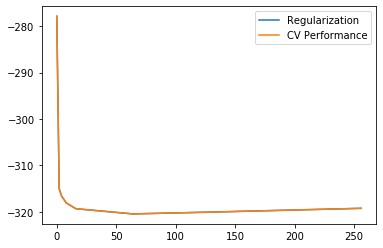

In [17]:
results_df = pd.DataFrame(cv_results, index=['Regularization', "CV Performance"])
results_df.T.plot();

Based on the cross-validation results the best performance of the model happens when $\lambda = 64$. We can also see that the model performance changes little after $\lambda = 4$. Perhaps it makes sense to average several models of comparable performance. Let's see the results generated by the best model:

In [33]:
result = run_experiment(salary_experience_array, 64, 500, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.1763, 'Fit to data': 12.90124}

In [34]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,5.68973,1.30630,1.50247,0.35553,0.32165,0.43054,0.53850,2.22560,0.44372
1351-1750,7.71055,5.01276,4.78635,2.98537,0.58018,1.51411,1.66769,1.36694,0.81316
1751-2150,9.47247,10.56914,6.71977,1.73339,3.90291,2.61106,2.83336,1.61330,2.59546
2151-2550,1.34993,1.69919,6.76907,2.93928,2.88506,2.93574,4.30820,0.53217,3.55131
2551-2950,1.20816,0.93791,3.19687,2.07677,0.51816,4.92782,4.20533,2.07660,5.44199
2951-3750,1.50375,0.62231,1.57091,0.39049,1.24524,1.29622,5.13467,0.32709,2.04776


We see a good balance between prediction smoothness and how well it fit the training data.

## Conclusion
Here we considered a fully Bayesian approach for contingency table smoothing. This approach is different from pseudo-Bayes approach, where the prior distribution is defined using the data. The approach shows good results and is recommended to use for multidimensional contingency tables.